In [35]:
import numpy as np 
import pandas as pd 
import numpy as np 
import pandas as pd
import xarray as xr
import openpyxl
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import *
import matplotlib.colors as colors
from scipy import stats 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point


In [36]:
iyr=2000
fyr=2023
domain='GRa'
domainO='MARMer'
variable='pr'
var='pr'
units='mm/month'
exp='obs'

model1='MAR'
res1='5x5km'

model2='chirps'
res2='0.05°x0.05°'

model3='cru'

model4='aphro'
res4=str('0.25°x0.25°')

model5='gpcp'
res5=str('1.0°x1.0°')



titles = {
    'MAM': 'MAM',
    'JJAS': 'JJAS',
    'ON': 'ON',
    'DJF': 'DJF',
}


In [37]:
## GRID Model MAR
sourceDataGrid='/home/amoryc/'
#fileName_grF='NST.2000.01.01.00.GRa_Fedchenko.nc'
fileName_grM='NST.2000.01.01.00.GRa_Mera.nc_ICEmask'
ds_grM= xr.open_dataset(sourceDataGrid+fileName_grM)

In [38]:
sourceData='/bettik/PROJECTS/pr-regional-climate/santolam/'

In [39]:
####
## MAR
####
sourceData1='/bettik/PROJECTS/pr-regional-climate/santolam/MARout/GRa/spin2/work/monthly/'
dsM_SF= xr.open_dataset(sourceData1+'RF_mon_MARv3.14_ER5_spin2_GRa_2000-2023.nc')['RF']
dsM_RF= xr.open_dataset(sourceData1+'SF_mon_MARv3.14_ER5_spin2_GRa_2000-2023.nc')['SF']

FieldMAR=dsM_RF+dsM_SF
FieldMAR = FieldMAR.rename({'TIME': 'time'})

In [40]:
####
## CHIRPS
####
model2='chirps'
res2='0.05°x0.05°'

fileName2='chirps-v2.0.monthly_remap'+domainO+'.nc'
ds2b = xr.open_dataset(sourceData+model2+'/'+fileName2)['precip']
field2b=ds2b
FieldChirps=field2b.sel(time=slice(str(iyr)+'-01',str(fyr)+'-12'))
FieldChirps.shape


(288, 116, 164)

In [41]:
####
## CRU
####

res3=str('0.5°x0.5°')

fileName3='cru_ts4.05.1901.2020.pre.dat_remapMARMer.nc'
ds3 = xr.open_dataset(sourceData+model3+'/'+fileName3)['pre']
print(ds3.attrs)
FieldCRU=ds3.sel(time=slice(str(iyr)+'-01',str(fyr)+'-12'))
#units in mm/month -> mm/day
#field50=dom.field_dom(ds5,domain)
#month_length5 = field50.time.dt.days_in_month
#
#field5=field50/month_length5

FieldCRU=FieldCRU.rename({'lat': 'lat3'})
FieldCRU=FieldCRU.rename({'lon': 'lon3'})

{'long_name': 'precipitation', 'units': 'mm/month', 'correlation_decay_distance': np.float32(450.0)}


In [42]:
######
## APHRODITE
######


fileName4='APHRO_mon_MA_025deg_V1101_EXR1.1951-2015_remapMARMer.nc'
ds4 = xr.open_dataset(sourceData+model4+'/'+fileName4,decode_times=False)['precip']
start_date = pd.Timestamp('1951-01-01')
# Create new time index
nmonths = ds4.time.size
time_new = pd.date_range(start=start_date, periods=nmonths, freq='MS')  # 'MS' = Month Start
# Replace time in dataset
ds4['time'] = time_new


# Multiply by days in month to get mm/month
days_in_month4 = ds4['time'].dt.days_in_month
ds4_mm_per_month = ds4 * days_in_month4

# Update attributes
ds4_mm_per_month.attrs['units'] = 'mm/month'
ds4_mm_per_month.attrs['long_name'] = 'Total Monthly Precipitation'

FieldAphro=ds4_mm_per_month


FieldAphro=FieldAphro.rename({'lat': 'lat4'})
FieldAphro=FieldAphro.rename({'lon': 'lon4'})



In [43]:
######
## GPCP
######



fileName5='precip_mon.gpcp_v2020_1891_2019_10_remapMARMer.nc'
ds5= xr.open_dataset(sourceData+model5+'/'+fileName5)['precip']

FieldGPCP=ds5


FieldGPCP=FieldGPCP.rename({'lat': 'lat5'})
FieldGPCP=FieldGPCP.rename({'lon': 'lon5'})
FieldGPCP

<xarray.DataArray 'precip' (time: 1548, y: 116, x: 164)> Size: 118MB
[29449152 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 12kB 1891-01-01 1891-02-01 ... 2019-12-01
    lon5     (y, x) float32 76kB ...
    lat5     (y, x) float32 76kB ...
  * x        (x) float32 656B -495.0 -490.0 -485.0 -480.0 ... 310.0 315.0 320.0
  * y        (y) float32 464B -195.0 -190.0 -185.0 -180.0 ... 370.0 375.0 380.0
Attributes:
    long_name:    gpcc full data monthly product version 2020, precipitation ...
    units:        mm/month
    code:         20
    institution:  DWD

In [44]:
####
## Opening station data + Deff Var 
####


path1 ="/bettik/PROJECTS/pr-regional-climate/santolam/glacioclim/donnees_precip/Precipitation_Pyramid_Pheriche_corrected_Dec2012_Apr2016_final.xlsx"
xl_data1=pd.ExcelFile(path1)

dfs1= {sheet_name: xl_data1.parse(sheet_name) 
       for sheet_name in xl_data1.sheet_names}

DataPyramid_Pheriche12_16=dfs1['Precip_data_Dec12_Apr16']

NameVarsPP12_16=['TimeY','RRYhourly','RRYcumul','TimeH','RRHhourly','RRHcumul']
UnitVarsPP16_23=['data/hour','mm','mm','data/hour','mm','mm',]

dfile1P12_16= pd.DataFrame(data=DataPyramid_Pheriche12_16.loc[10:])
df1P12_16=pd.DataFrame(dfile1P12_16.values, columns=NameVarsPP12_16)

df1P12_16['TimeY'] = df1P12_16['TimeY'].dt.round('h')

path ="/bettik/PROJECTS/pr-regional-climate/santolam/glacioclim/donnees_precip/Precipitation_Pyramid_Pheriche_corrected_Apr2016_Nov2023_final.xlsx"
xl_data=pd.ExcelFile(path)

dfs = {sheet_name: xl_data.parse(sheet_name) 
       for sheet_name in xl_data.sheet_names}
DataPyramid_Pheriche16_23=dfs['Precip_data_Apr16_Nov23']

NameVarsPP16_23=['TimeY','TairY','uY','RHY','WMOphaseY','RRYhourly','RRYcumul','TimeH','TairH','uH','RHh','WMOphaseH','RRHhourly','RRHcumul']
UnitVarsPP16_23=['data/hour','(°C)','(ms-1)','(%)','mm','mm','data/hour','(°C)','(ms-1)','(%)','mm','mm',]

dfile1P16_23= pd.DataFrame(data=DataPyramid_Pheriche16_23.loc[10:57630]) #3399 marche, Toujours la même taille jusque 3399 puis toujours lenght var=t-1 par la suite 
#CHANGEMENT DANS TIME:3389 	2016-09-15 17:59:59.!999! / 2016-09-15 18:59:59.!998! 
#donc erreur à chaque changement de décimale, corriger cette data avant tout autre chose



dfile2P16_23=pd.DataFrame(data=DataPyramid_Pheriche16_23.loc[57632:]) 
df1P16_23=pd.DataFrame(dfile1P16_23.values, columns=NameVarsPP16_23)
df2P16_23=pd.DataFrame(dfile2P16_23.values, columns=NameVarsPP16_23)
df1P16_23['TimeY'] = df1P16_23['TimeY'].dt.round('h')
df2P16_23['TimeY'] = df2P16_23['TimeY'].dt.round('30min')

def NewTime(df, NameVar, values, freq):
	time = pd.to_datetime(df['TimeY'].values)
	ds = xr.Dataset({NameVar: ("time", np.asarray(values))}, coords={"time": time})
	return ds
# Time step: 1h

RR1=[float(thing) for thing in df1P12_16['RRYhourly'].values]

RRY1 = [float(thing) for thing in df1P16_23['RRYhourly'].values]

dsY1 = NewTime(df1P16_23, 'RRYhourly', RRY1, '1h')

dsRR1= NewTime(df1P12_16, 'RRYhourly', RR1, '1h')

# Time step : 30 min 
RRY2 = [float(thing) for thing in df2P16_23['RRYhourly'].values]

dsY2 = NewTime(df2P16_23, 'RRYhourly', RRY2, '30min')

RR = xr.concat([dsRR1,dsY1, dsY2], dim='time')



In [45]:
######
## Finding Pixel MAR (i,j)
######

#Glacioclim station location

lon_Station_Glacioclim=86.81296905961787
lat_Station_Glacioclim=27.957821815535848
elev_Station_Glacioclim=5035

##Find the pixel of MAR corresponding to station
target_lon = lon_Station_Glacioclim
target_lat = lat_Station_Glacioclim
lon=ds_grM.LON
lat=ds_grM.LAT


#Step 2: Find the nearest grid point to target_lon,target_lat
# Compute distance to each grid point
dist = np.sqrt((lon - target_lon)**2 + (lat - target_lat)**2)
#print(dist)
j, i = np.unravel_index(dist.argmin(), dist.shape)

#Step 3: Extract data at that location
# For a single time step
#value = dsM['SH'].isel(y=j, x=i)
## If there's a time dimension
dsM_MAR=FieldMAR[0:, i, j]

#units=dsM.units

#BONUS FOR MAR
SH_sta=elev_Station_Glacioclim
value = ds_grM['SH'].isel(y=j, x=i)
diff=SH_sta-value.values
value.values,SH_sta, diff
print(i,j)

97 45


In [46]:
######
## Finding Pixel Chirps (k,l)
######

##Find the pixel of Chirps corresponding to station
target_lon = lon_Station_Glacioclim
target_lat = lat_Station_Glacioclim
lon2=FieldChirps.lon
lat2=FieldChirps.lat
#Step 2: Find the nearest grid point to target_lon,target_lat
# Compute distance to each grid point
dist = np.sqrt((lon2 - target_lon)**2 + (lat2 - target_lat)**2)
l, k = np.unravel_index(dist.argmin(), dist.shape)
print(i,j)
#Step 3: Extract data at that location
# For a single time step
#value = dsM['SH'].isel(y=j, x=i)
## If there's a time dimension

dsM_Chirps=FieldChirps[0:, k, l]

97 45


In [47]:
######
## Finding Pixel CRY (m,n)
######
##Find the pixel of Chirps corresponding to station
target_lon = lon_Station_Glacioclim
target_lat = lat_Station_Glacioclim
lon3=FieldCRU.lon3
lat3=FieldCRU.lat3
#Step 2: Find the nearest grid point to target_lon,target_lat
# Compute distance to each grid point
dist = np.sqrt((lon3 - target_lon)**2 + (lat3 - target_lat)**2)
n, m = np.unravel_index(dist.argmin(), dist.shape)
print(m,n)
#Step 3: Extract data at that location
# For a single time step
#value = dsM['SH'].isel(y=j, x=i)
## If there's a time dimension

dsM_CRU=FieldCRU[0:, m, n]

97 45


In [48]:
######
## Finding Pixel Aphro (o,p)
######
##Find the pixel of Aphro corresponding to station
target_lon = lon_Station_Glacioclim
target_lat = lat_Station_Glacioclim
lon4=FieldAphro.lon4
lat4=FieldAphro.lat4
#Step 2: Find the nearest grid point to target_lon,target_lat
# Compute distance to each grid point
dist = np.sqrt((lon4 - target_lon)**2 + (lat4 - target_lat)**2)
p, o = np.unravel_index(dist.argmin(), dist.shape)
print(o,p)
#Step 3: Extract data at that location
# For a single time step
#value = dsM['SH'].isel(y=j, x=i)
## If there's a time dimension

dsM_Aphro=FieldCRU[0:, o, p]

97 45


In [49]:

######
## Finding Pixel GPXP (q,r)
######

target_lon = lon_Station_Glacioclim
target_lat = lat_Station_Glacioclim
lon5=FieldGPCP.lon5
lat5=FieldGPCP.lat5
#Step 2: Find the nearest grid point to target_lon,target_lat
# Compute distance to each grid point
dist = np.sqrt((lon5 - target_lon)**2 + (lat5 - target_lat)**2)
r, q = np.unravel_index(dist.argmin(), dist.shape)
print(o,p)
#Step 3: Extract data at that location
# For a single time step
#value = dsM['SH'].isel(y=j, x=i)
## If there's a time dimension

dsM_GPCP=FieldGPCP[0:, q, r]









97 45


In [60]:
######
## Definition fonctions
######


#Définition des Saisons, et création d'une fonction qui définit les saisons en fonction des périodes des moussons:
seasons = {
	'MAM': [3, 4, 5],  	
	'JJAS': [6, 7, 8, 9],  
	'ON': [10, 11],    	
	'DJF': [12, 1, 2]  	
}
def seasonsdata(ds, season_name): 
	x = seasons[season_name]
	return ds.sel(time=ds['time'].dt.month.isin(x))

#Fonction Clim de base 

#Util pour les Températures exprimées dans les fichiers glacioclim
def Clim_mean(ds, variable):
    daily = ds[variable].resample(time='D').mean()
    monthly = daily.resample(time='ME').mean()
    yearly = monthly.resample(time='YE').mean()

    return {
        'daily': daily.to_dataset(name=variable),
        'monthly': monthly.to_dataset(name=variable),
        'yearly': yearly.to_dataset(name=variable)
    }

#Util pour les Précips exprimées dans les fichiers glacioclim
def Clim_sum(ds, variable):
    daily = ds[variable].resample(time='D').sum()
    monthly = daily.resample(time='ME').sum()
    yearly = monthly.resample(time='YE').sum()

    return {
        'daily': daily.to_dataset(name=variable),
        'monthly': monthly.to_dataset(name=variable),
        'yearly': yearly.to_dataset(name=variable)
    }


# Precip sta classic climatic variables. Donne un DataArray, Timeseries des moyennes de précip saisonnières sur la période considérée

def seasonal_annual_Precip(datasets, seasons):

    return {
        name: {
            season: seasonsdata(ds, season).resample(time='YE').mean()
            for season in seasons
        }
        for name, ds in datasets.items()
    }

#Même fonction mais pour les données des Models considérés.
def Model_seasonal_timeseries(ds, model_name='Chirps'):
    # Suffixes pour noms de variable
    suffix_map = {
        'MAM': 'premon',
        'JJAS': 'mon',
        'ON': 'postmon',
        'DJF': 'hiver'
    }

    seasonal_dict = {}

    for season, suffix in suffix_map.items():
        ts = seasonsdata(ds, season).resample(time='YE').mean()
        var_name = f'Timeseries_{model_name}_{suffix}'
        globals()[var_name] = ts  # Création de la variable globale
        seasonal_dict[season] = ts

    return seasonal_dict

In [61]:
######
## Premier Traitement climato
######

In [62]:
#Précip station
Clim_precip_Pyramide=Clim_sum(RR,'RRYhourly')
#définition temps commun pour toutes les données ( bordés sur celle de station en entrée, et la première donnée à manquer en sortie[aussi station])

time1 = Clim_precip_Pyramide['monthly']['time']# début 
start=time1[0] 
end=time1[-1]



Pr_sta=Clim_precip_Pyramide['monthly'].sel(time=slice(start,end))
Pr_MAR=dsM_MAR.sel(time=slice(start,end))
Pr_Chirps=dsM_Chirps.sel(time=slice(start,end))
Pr_CRU=dsM_CRU.sel(time=slice(start,end))
Pr_Aphro=dsM_Aphro.sel(time=slice(start,end))
Pr_GPCP=dsM_GPCP.sel(time=slice(start,end))


In [63]:
#Précip station suite

ClimBasis_precip_Pyramide=Clim_sum(RR,'RRYhourly')

seasonal_precip_Pyramide= seasonal_annual_Precip(Pr_sta, seasons)



In [64]:
#Précip Models
#Seasonnal
seasonnal_precip_MAR=Model_seasonal_timeseries(Pr_MAR)

seasonnal_precip_Chirps=Model_seasonal_timeseries(Pr_Chirps)

seasonnal_precip_CRU=Model_seasonal_timeseries(Pr_CRU)

seasonnal_precip_Aphro=Model_seasonal_timeseries(Pr_Aphro)

seasonnal_precip_GPCP=Model_seasonal_timeseries(Pr_GPCP)
#Annual cycle

PrMAR_cycle=Pr_MAR.groupby('time.month').mean()
PrChirps_cycle=Pr_Chirps.groupby('time.month').mean()
PrCRU_Cycle=Pr_CRU.groupby('time.month').mean()
PrAphro_Cycle=Pr_Aphro.groupby('time.month').mean()
PrGPCP_cycle=Pr_GPCP.groupby('time.month').mean()


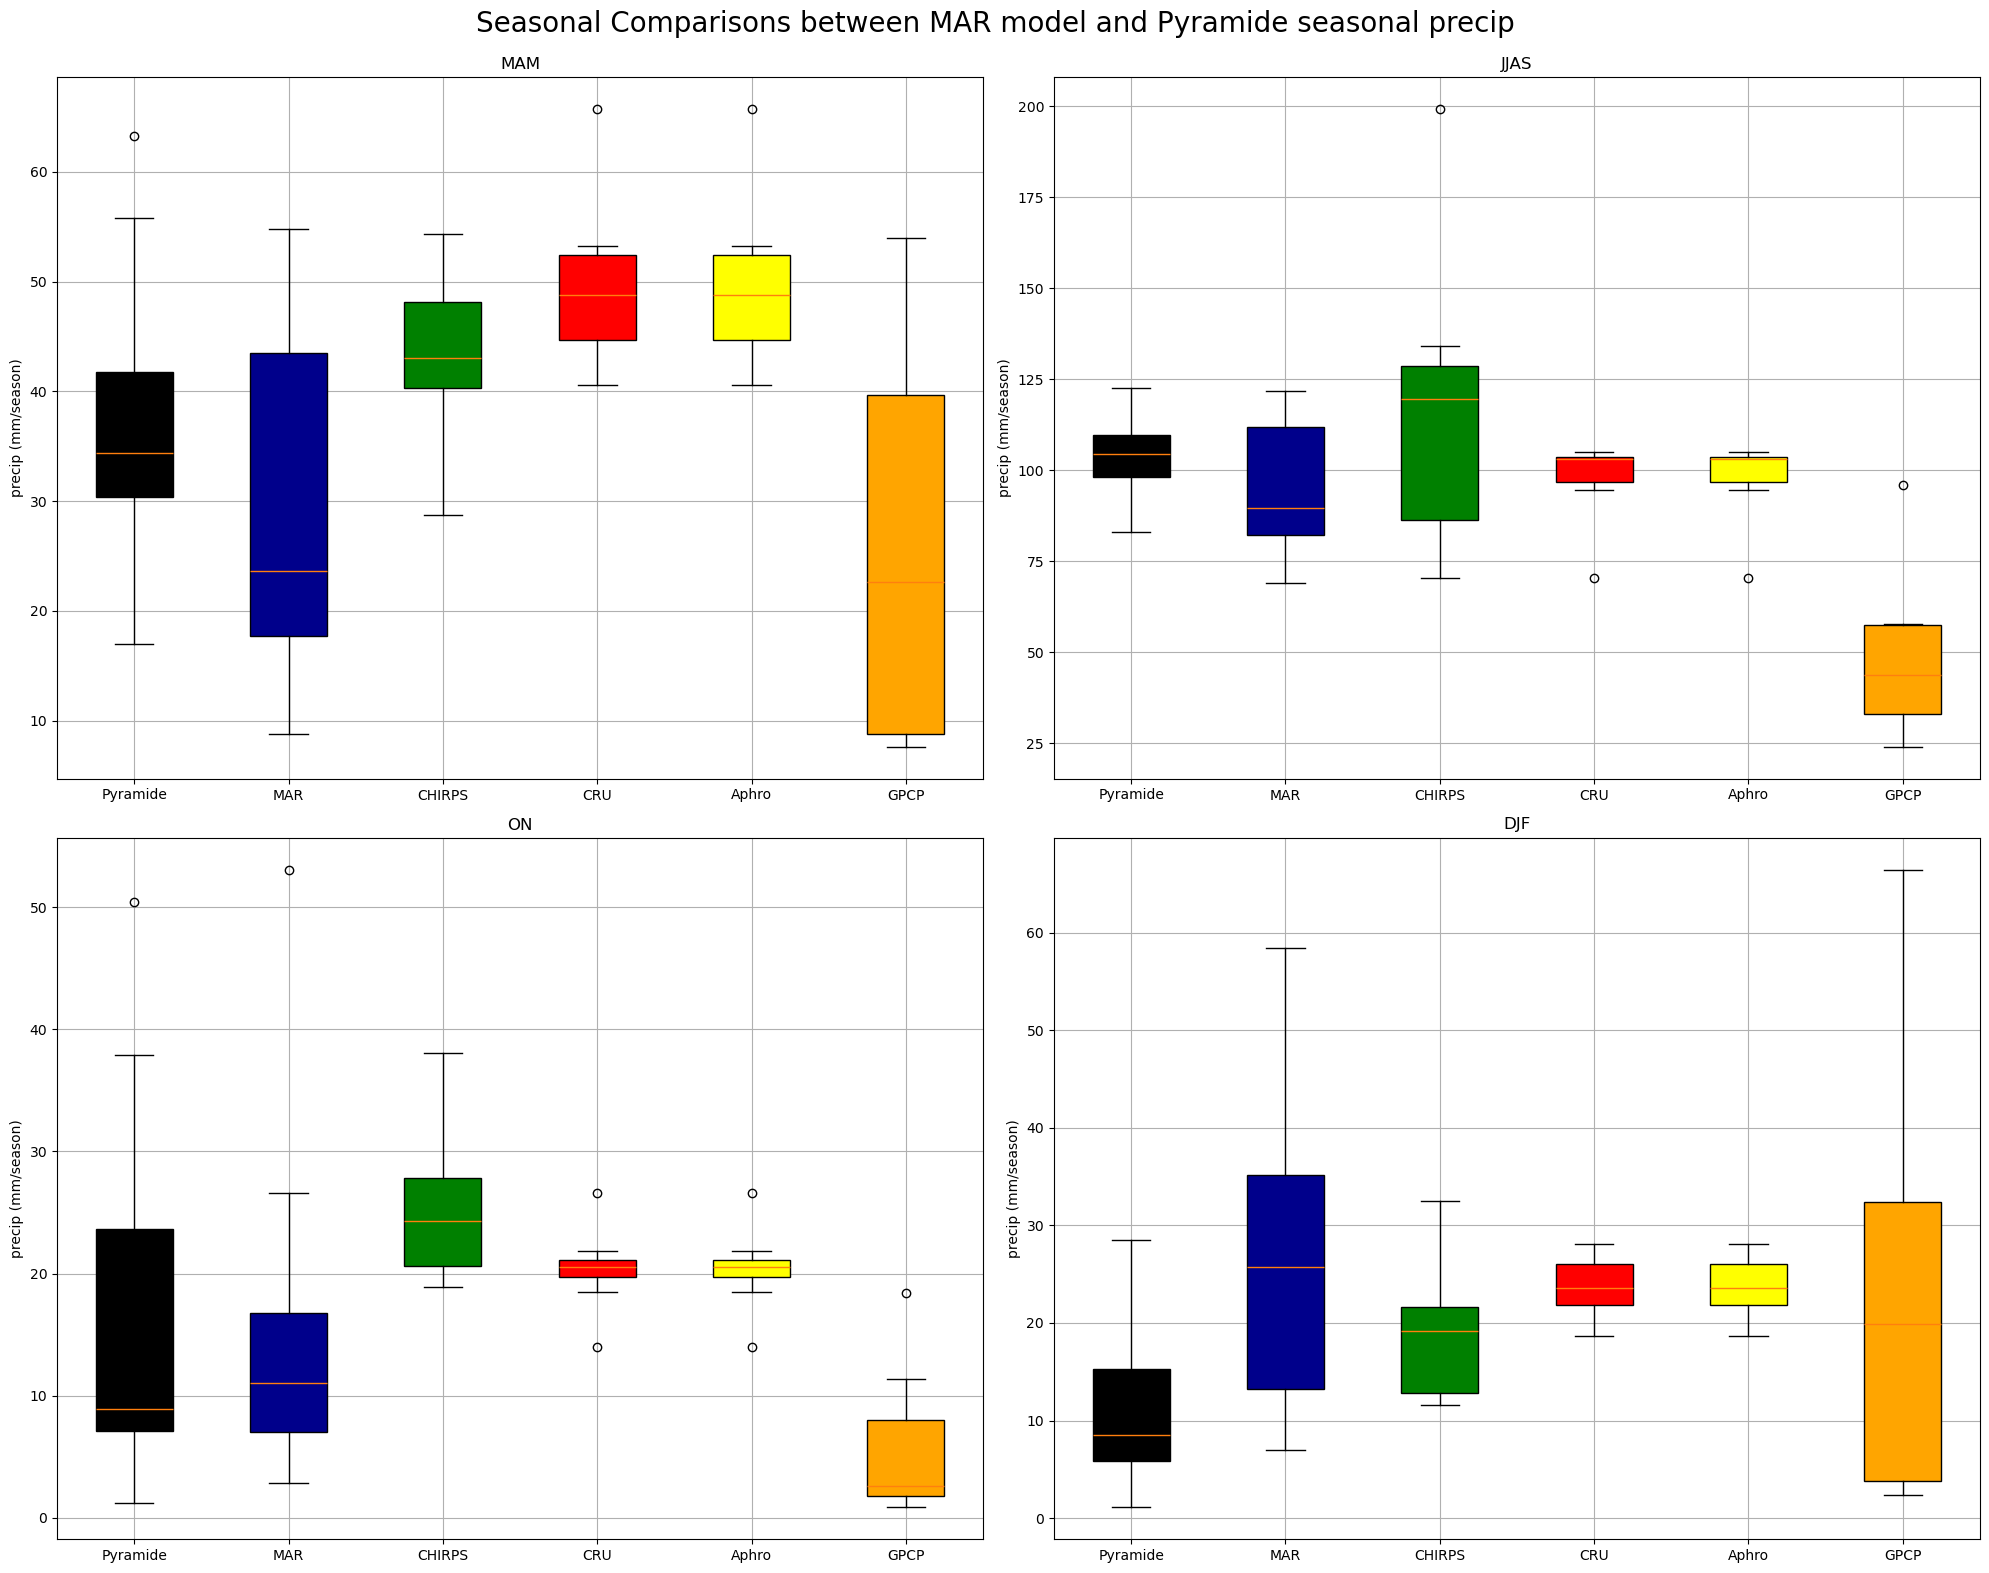

In [65]:

# Création de la figure
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

for things, x in enumerate(seasons):
    ax = axes[things]

    # Extract seasonal data
    da_py = seasonal_precip_Pyramide['RRYhourly'][x].values
    da_mar = seasonnal_precip_MAR[x].values
    da_chirps = seasonnal_precip_Chirps[x].values
    da_cru = seasonnal_precip_CRU[x].values
    da_aphro = seasonnal_precip_Aphro[x].values
    da_gpcp = seasonnal_precip_GPCP[x].values

    # Combine into list for boxplot
    data = [da_py, da_mar, da_chirps, da_cru, da_aphro, da_gpcp]
    tick_labels = ['Pyramide', 'MAR', 'CHIRPS', 'CRU', 'Aphro', 'GPCP']
    colors = ['black', 'darkblue', 'green', 'red', 'yellow', 'orange']
    
    bp = ax.boxplot(data, patch_artist=True, tick_labels=tick_labels)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    ax.set_title(titles[x])
    ax.set_ylabel('precip (mm/season)')
    ax.grid(True)
    ax.legend
plt.tight_layout(rect=[0, 0, 1, 0.96])
fig.suptitle('Seasonal Comparisons between MAR model and Pyramide seasonal precip', fontsize=20)
plt.show()


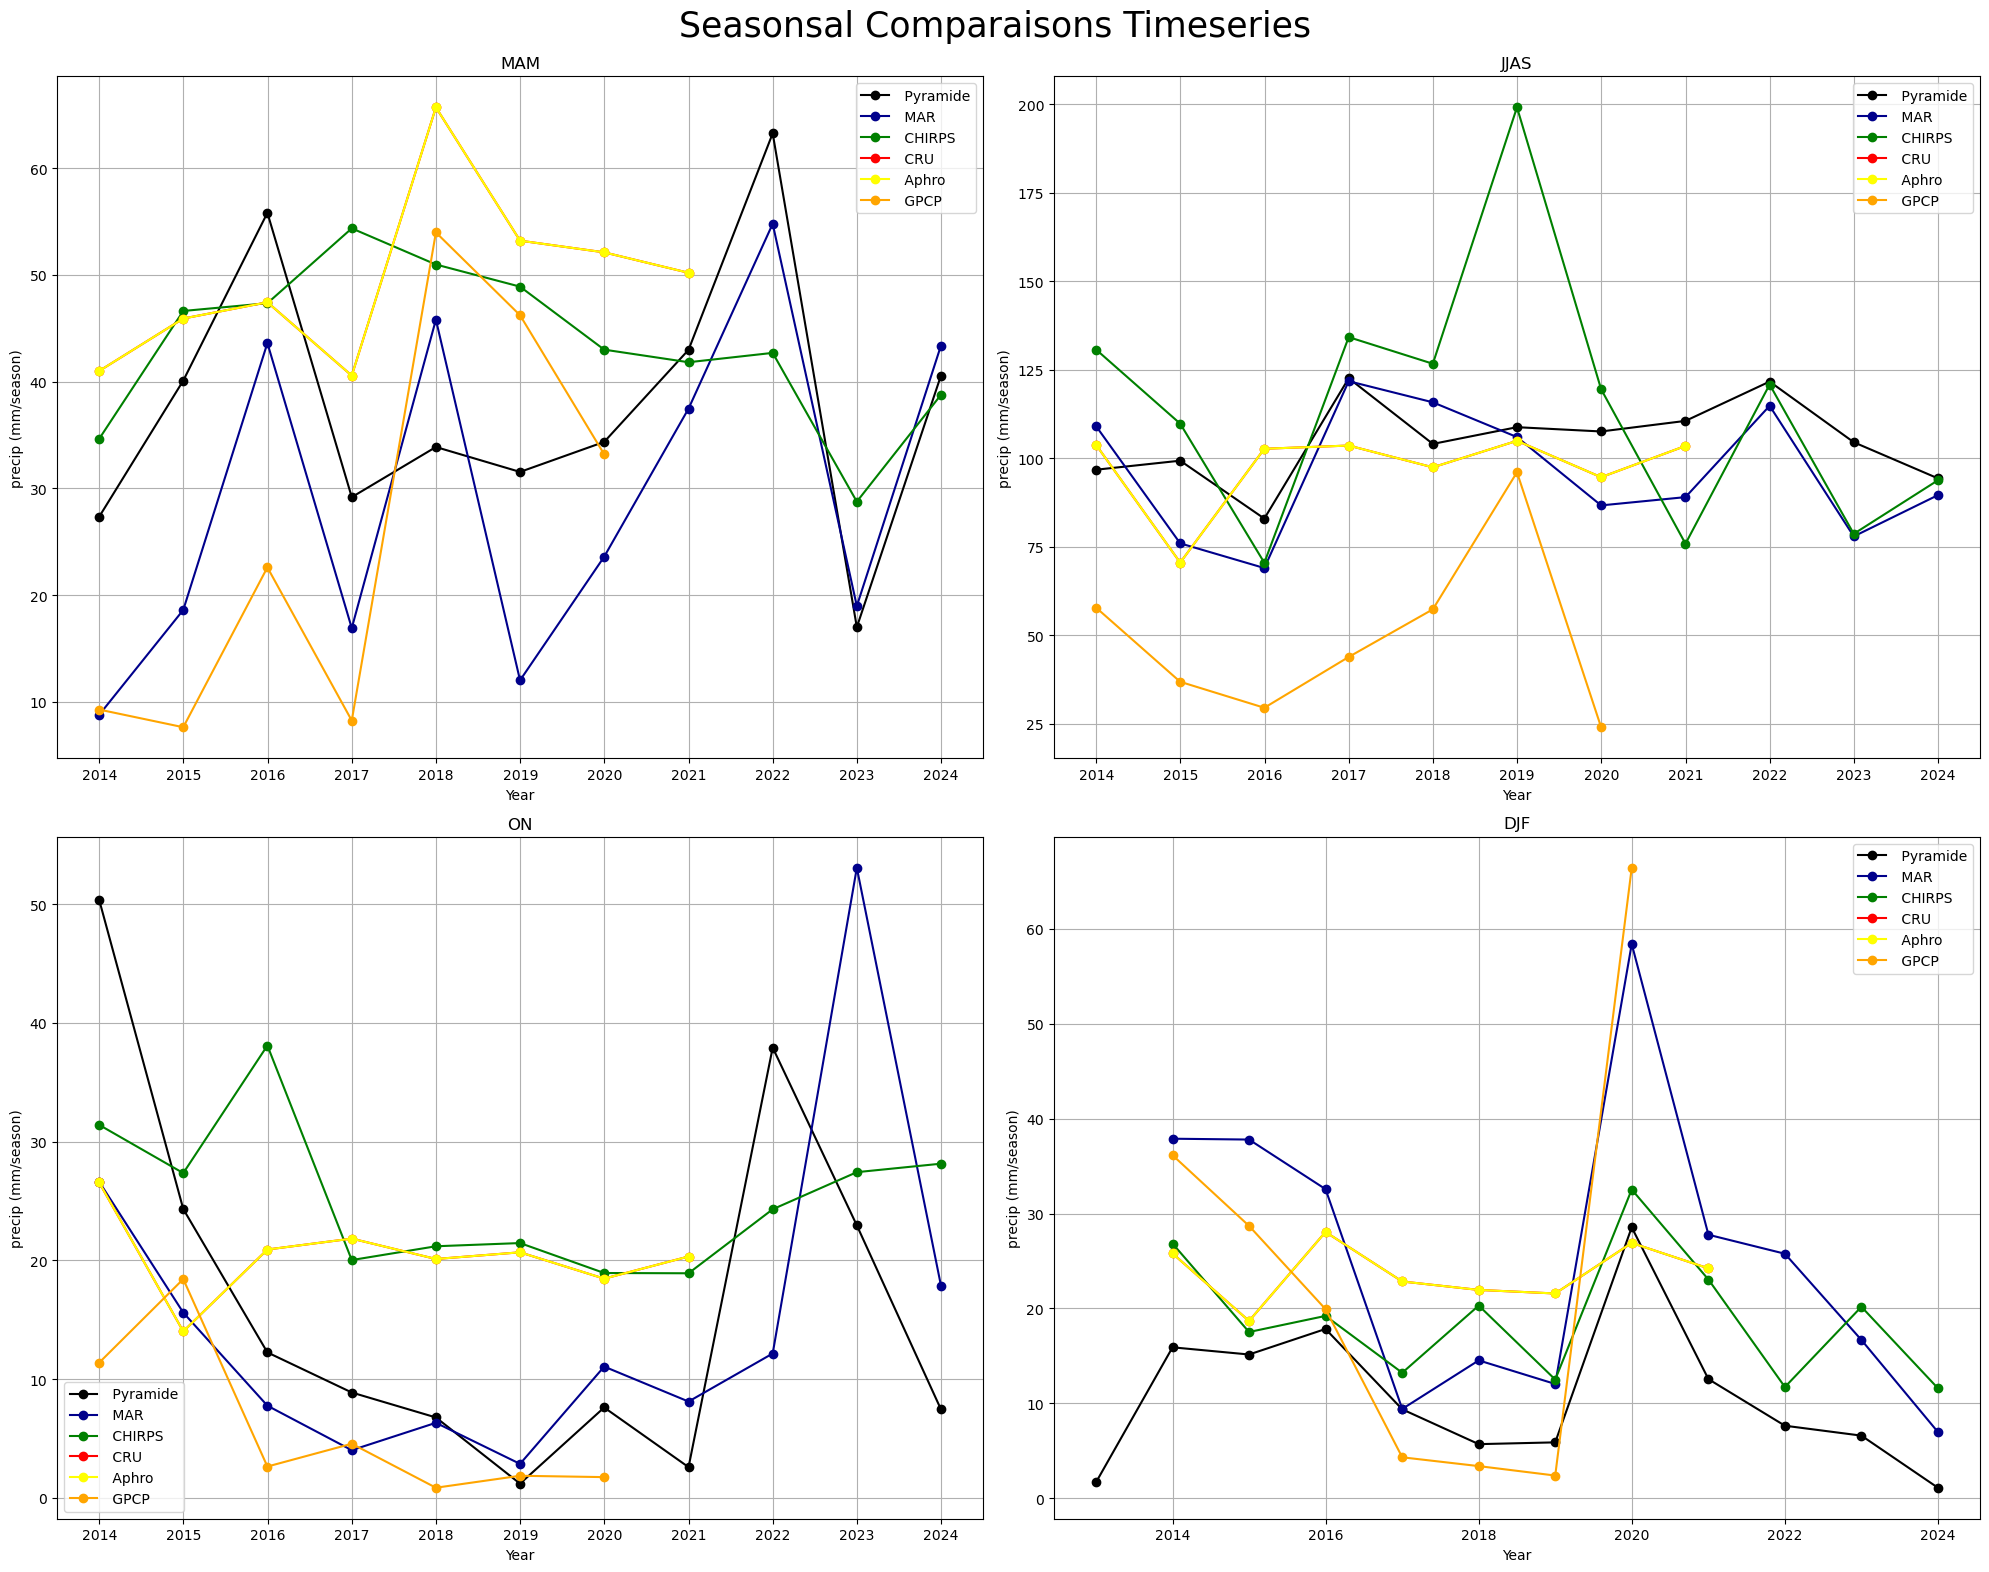

In [79]:

# Création de la figure
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

for thing, x in enumerate(seasons):
    ax = axes[thing]

    # Pyramide
    da_py = seasonal_precip_Pyramide['RRYhourly'][x]
    # MAR
    da_mar = seasonnal_precip_MAR[x]
    #Chirps
    da_chirps= seasonnal_precip_Chirps[x]
    #Cru
    da_cru= seasonnal_precip_CRU[x]
    #Aphro
    da_aphro=seasonnal_precip_Aphro[x]
    #GPCP
    da_gpcp=seasonnal_precip_GPCP[x]

    # Tracés
    ax.plot(da_py.time, da_py.values, linestyle='-', marker='o', label=' Pyramide',color='black')
    ax.plot(da_mar.time, da_mar.values, linestyle='-', marker='o', label=' MAR',color='darkblue')
    ax.plot(da_chirps.time, da_chirps.values, linestyle='-', marker='o', label=' CHIRPS',color='green')
    ax.plot(da_cru.time, da_cru.values, linestyle='-', marker='o', label=' CRU',color='red')
    ax.plot(da_aphro.time, da_aphro.values, linestyle='-', marker='o', label=' Aphro',color='Yellow')
    ax.plot(da_gpcp.time, da_gpcp.values, linestyle='-', marker='o', label=' GPCP',color='orange')

    # Mise en forme
    ax.set_title(titles[x])
    ax.set_xlabel('Year')
    ax.set_ylabel('precip (mm/season)')
    ax.grid(True)
    ax.legend()


plt.tight_layout(rect=[0, 0, 1, 0.96])  # Maria script theft : leave space for the suptitle
fig.suptitle('Seasonsal Comparaisons Timeseries',fontsize=25)
plt.show()


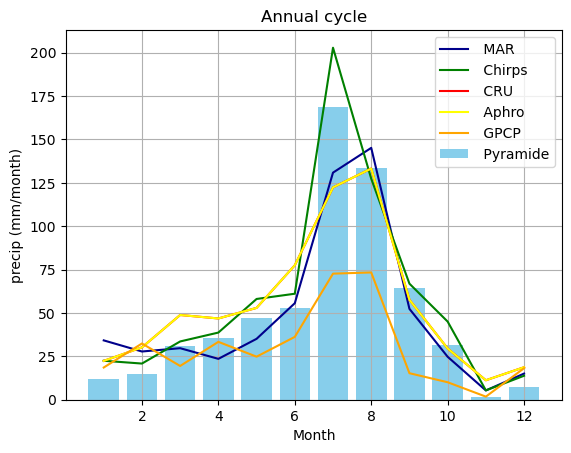

In [78]:
#Annual cycle 
#daily_meanRR=RR.resample(time='D').sum()  
Précip_cycle_sta=ClimBasis_precip_Pyramide['monthly'].groupby('time.month').mean()


plt.bar(Précip_cycle_sta.month,Précip_cycle_sta.RRYhourly,
        color='skyblue',linestyle='-',label=' Pyramide')
plt.plot(PrMAR_cycle.month,PrMAR_cycle.values,
         color='darkblue',linestyle='-',label=' MAR')
plt.plot(PrChirps_cycle.month,PrChirps_cycle.values,
         color='green',linestyle='-',label=' Chirps')    
plt.plot(PrCRU_Cycle.month,PrCRU_Cycle.values,
         color='red',linestyle='-',label=' CRU')    
plt.plot(PrAphro_Cycle.month,PrAphro_Cycle.values,
         color='Yellow',linestyle='-',label=' Aphro')    
plt.plot(PrGPCP_cycle.month,PrGPCP_cycle.values,
         color='orange',linestyle='-',label=' GPCP')    




plt.legend()
plt.title('Annual cycle')
plt.xlabel('Month')
plt.ylabel('precip (mm/month)')

plt.grid(True)